In [101]:
# Import các thư viện & module cần thiết
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np

import os
import pickle
from scipy.fftpack import dct

## Basic Features Plot

### 1. Harmonic/Percussive Source Separation (HPSS)

## Detective Features Plot

In [102]:
MX_TIME_STP = 109
SAMPLE_RATE = 16000  # SR của file âm thanh
DURATION = 5  # Thời gian file âm thanh
N_MELS = 128  # Số Mel Bin
N_COF = 29

In [103]:
# CQCC (Cepstral Coefficients of Constant-Q Transform) creation
def load_audio(filepath, sr=None):
    y, sr = librosa.load(filepath, sr=sr)
    return y, sr

def compute_cqt(y, sr, n_bins=84, bins_per_octave=12):
    cqt = np.abs(librosa.cqt(y, sr=sr, n_bins=n_bins, bins_per_octave=bins_per_octave)) ** 2
    return cqt

def log_compress(spectrum):
    return np.log1p(spectrum)
    
def uniform_sampling(log_spectrum, num_samples=50):
    indices = np.linspace(0, log_spectrum.shape[0] - 1, num_samples, dtype=int)
    return log_spectrum[indices, :]

def compute_dct(log_cqt):
    cqcc = dct(log_cqt, type=2, axis=0, norm='ortho')
    return cqcc

def extract_cqcc(y, sr, num_samples=60, num_coefficients=29):
    cqt = compute_cqt(y, sr)
    log_cqt = log_compress(cqt)
    sampled_log_cqt = uniform_sampling(log_cqt, num_samples)
    
    # DCT 
    cqcc = compute_dct(sampled_log_cqt)
    
    # Lấy những bin đầu của tần âm phổ,...
    return cqcc[:num_coefficients, :]

In [104]:
folder_path = "D:/DEEPFAKE_DETECTION/PROJECT/2.Vietnamese_VN/Run/RunAudi/"
bonafide_file_name = "run_0212_b.wav"
spoof_file_name = "run_0212_s.wav"

audiS = folder_path + spoof_file_name
audiB = folder_path + bonafide_file_name

In [105]:
dataS, srS = librosa.load(audiS, sr = 16000)
dataB, srB = librosa.load(audiB, sr = 16000)

In [106]:
print("Spoof Audio sound run: ")
IPython.display.Audio(dataS, rate=srS)

Spoof Audio sound run: 


In [107]:
print("Bonafide Audio sound run: ")
IPython.display.Audio(dataB, rate=srB)

Bonafide Audio sound run: 


### 1. Mel-Spectrogram in dB Visualization

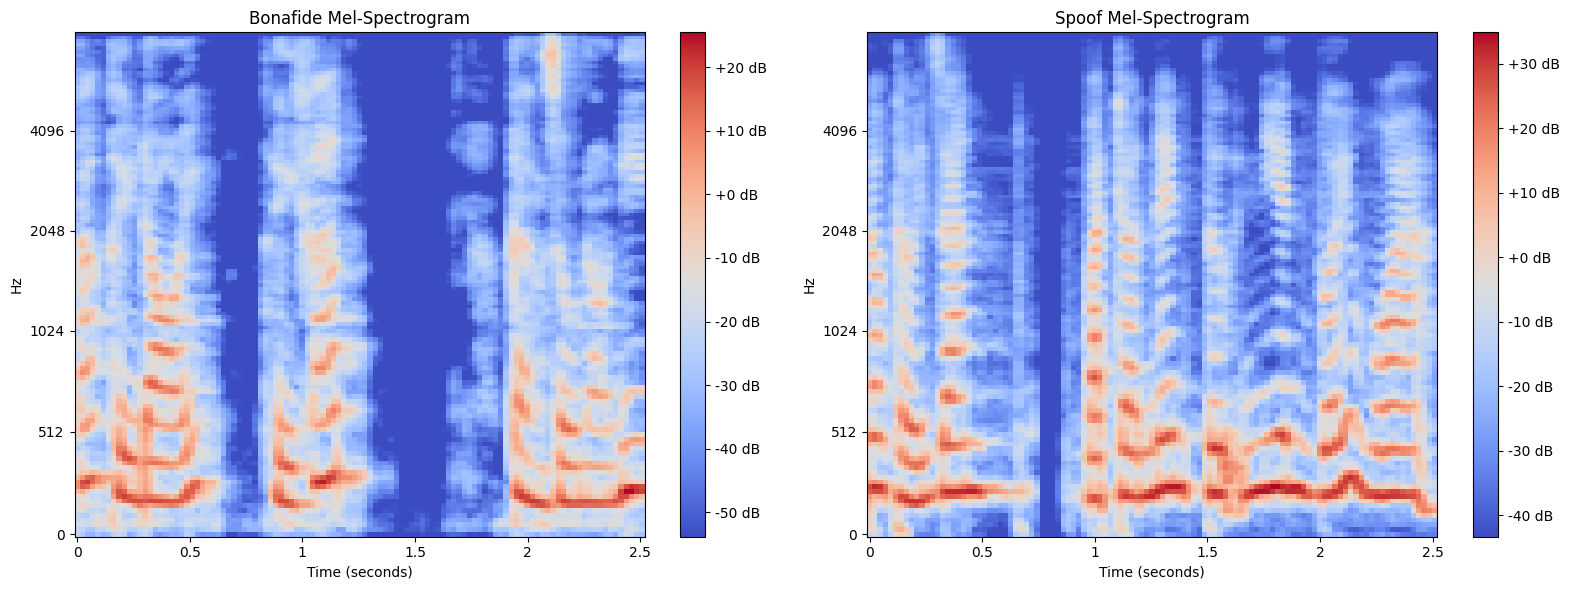

In [108]:
hop_length = 512
MS_b = librosa.feature.melspectrogram(y=dataB, sr=srB, n_mels=128, fmax=srB//2)
MS_b = librosa.power_to_db(MS_b)
MS_s = librosa.feature.melspectrogram(y=dataS, sr=srS, n_mels=128, fmax=srS//2)
MS_s = librosa.power_to_db(MS_s)



if MS_b.shape[1] < MX_TIME_STP:
    MS_b = np.pad(MS_b, ((0, 0), (0, MX_TIME_STP - MS_b.shape[1])), mode='constant')
else:
    MS_b = MS_b[:, :MX_TIME_STP]

if MS_s.shape[1] < MX_TIME_STP:
    MS_s = np.pad(MS_s, ((0, 0), (0, MX_TIME_STP - MS_s.shape[1])), mode='constant')
else:
    MS_s = MS_s[:, :MX_TIME_STP]



plt.figure(figsize=(16, 6))

# Bonafide audio
plt.subplot(1, 2, 1)

librosa.display.specshow(MS_b, y_axis='mel', fmax=srB//2, x_axis='s', hop_length= hop_length)
plt.title('Bonafide Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')

# Spoof audio
plt.subplot(1, 2, 2)

librosa.display.specshow(MS_s, y_axis='mel', fmax=srS//2, x_axis='s', hop_length = hop_length)
plt.title('Spoof Mel-Spectrogram')

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

### 2. MFCCs in dB Visualization

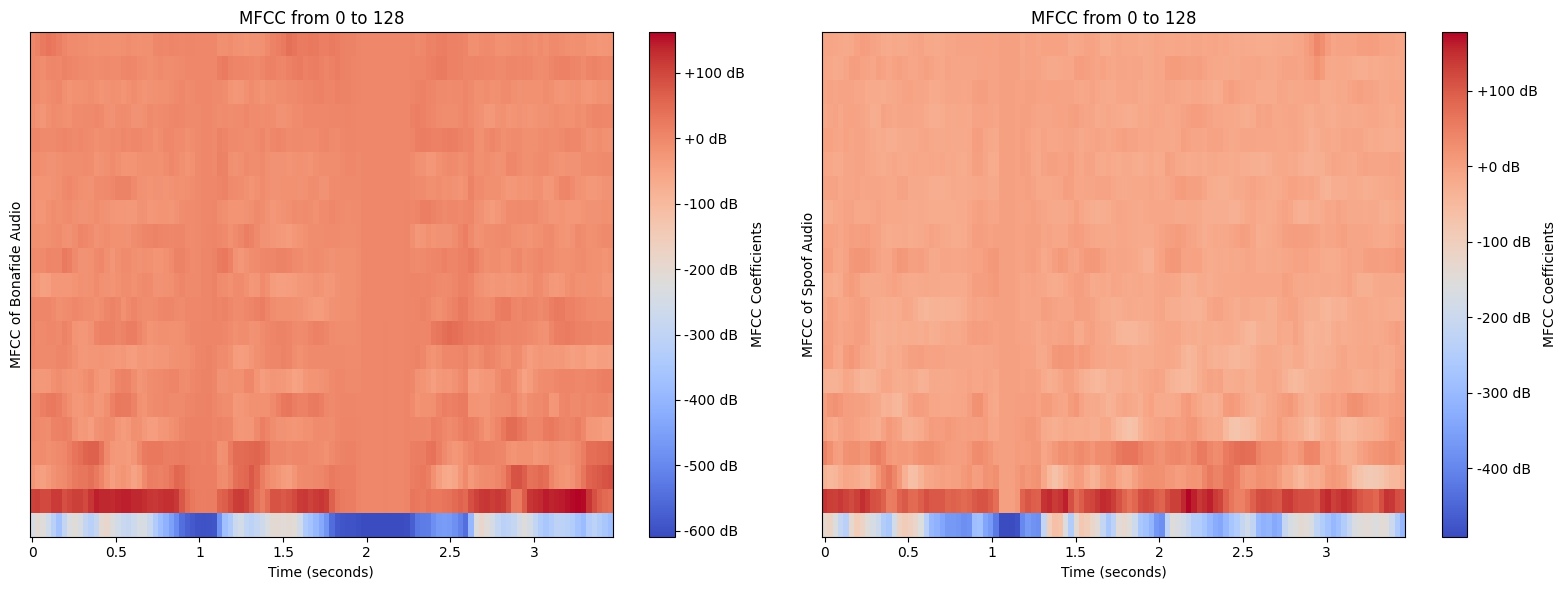

In [109]:
hop_length = 512  # Default hop_length for MFCC

mfccB = librosa.feature.mfcc(y=dataB, sr=srB, n_mfcc=21, hop_length=hop_length)
mfccS = librosa.feature.mfcc(y=dataS, sr=srS, n_mfcc=21, hop_length=hop_length)
# Pad or truncate MFCC to fit the model's input shape
if mfccB.shape[1] < MX_TIME_STP:
    mfccB = np.pad(mfccB, ((0, 0), (0, MX_TIME_STP - mfccB.shape[1])), mode='constant')
else:
    mfccB = mfccB[:, :MX_TIME_STP]

if mfccS.shape[1] < MX_TIME_STP:
    mfccS = np.pad(mfccS, ((0, 0), (0, MX_TIME_STP - mfccS.shape[1])), mode='constant')
else:
    mfccS = mfccS[:, :MX_TIME_STP]

plt.figure(figsize=(16, 6))
# Bonafide audio
plt.subplot(1, 2, 1)
librosa.display.specshow(mfccB, x_axis='s', sr=srB, hop_length=hop_length)
plt.colorbar(label='MFCC Coefficients', format='%+2.0f dB')
plt.ylabel('MFCC of Bonafide Audio')
plt.title('MFCC from 0 to 128')

# Spoof audio
plt.subplot(1, 2, 2)
librosa.display.specshow(mfccS, x_axis='s', sr=srS, hop_length=hop_length)
plt.colorbar(label='MFCC Coefficients', format='%+2.0f dB')
plt.ylabel('MFCC of Spoof Audio')
plt.title('MFCC from 0 to 128')
plt.tight_layout()
plt.show()

### 3. CQCCs in dB Visualization

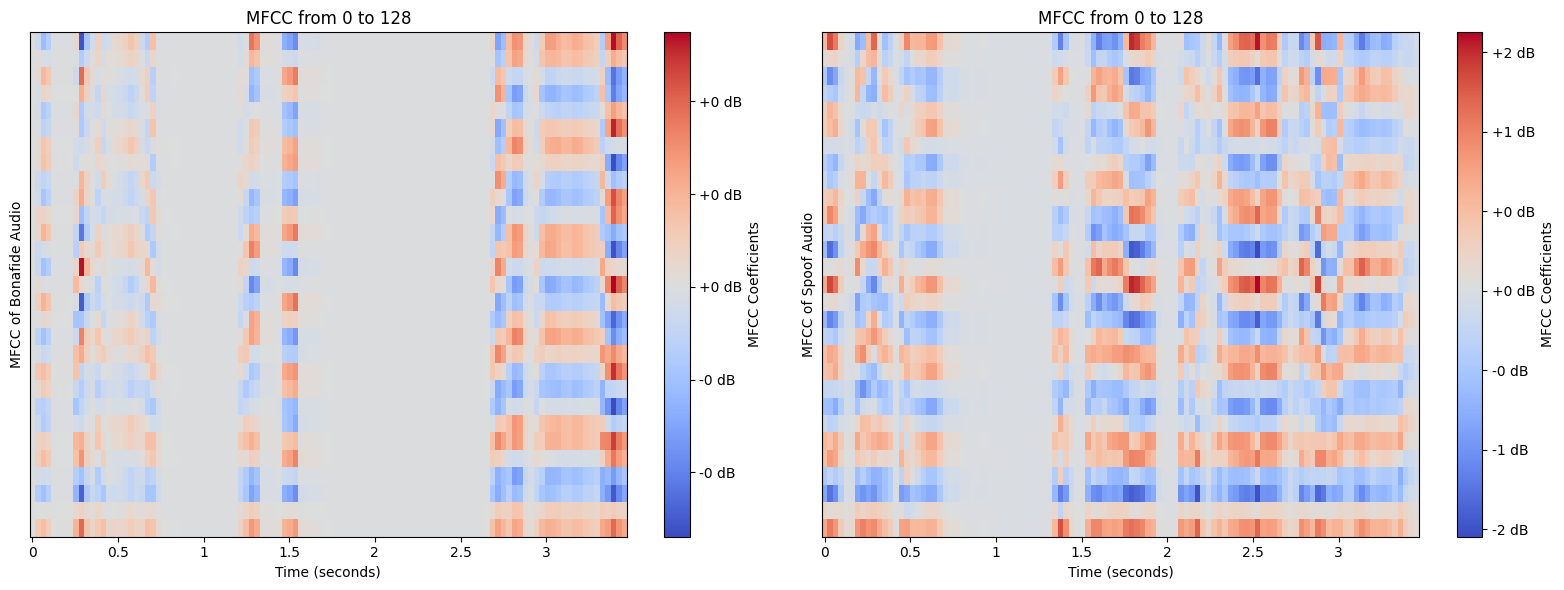

In [110]:
hop_length = 512  # Default hop_length for MFCC

cqccB = extract_cqcc(dataB, SAMPLE_RATE, N_COF)
cqccS = extract_cqcc(dataS, SAMPLE_RATE, N_COF)
# Pad or truncate MFCC to fit the model's input shape
if cqccB.shape[1] < MX_TIME_STP:
    cqccB = np.pad(cqccB, ((0, 0), (0, MX_TIME_STP - cqccB.shape[1])), mode='constant')
else:
    cqccB = cqccB[:, :MX_TIME_STP]

if cqccS.shape[1] < MX_TIME_STP:
    cqccS = np.pad(cqccS, ((0, 0), (0, MX_TIME_STP - cqccS.shape[1])), mode='constant')
else:
    cqccS = cqccS[:, :MX_TIME_STP]

plt.figure(figsize=(16, 6))
# Bonafide audio
plt.subplot(1, 2, 1)
librosa.display.specshow(cqccB, x_axis='s', sr=srB, hop_length=hop_length)
plt.colorbar(label='MFCC Coefficients', format='%+2.0f dB')
plt.ylabel('MFCC of Bonafide Audio')
plt.title('MFCC from 0 to 128')

# Spoof audio
plt.subplot(1, 2, 2)
librosa.display.specshow(cqccS, x_axis='s', sr=srS, hop_length=hop_length)
plt.colorbar(label='MFCC Coefficients', format='%+2.0f dB')
plt.ylabel('MFCC of Spoof Audio')
plt.title('MFCC from 0 to 128')
plt.tight_layout()
plt.show()

### 4. F0 in db Visualization

C:\Users\ACER\AppData\Local\Temp\ipykernel_19420\1102673479.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


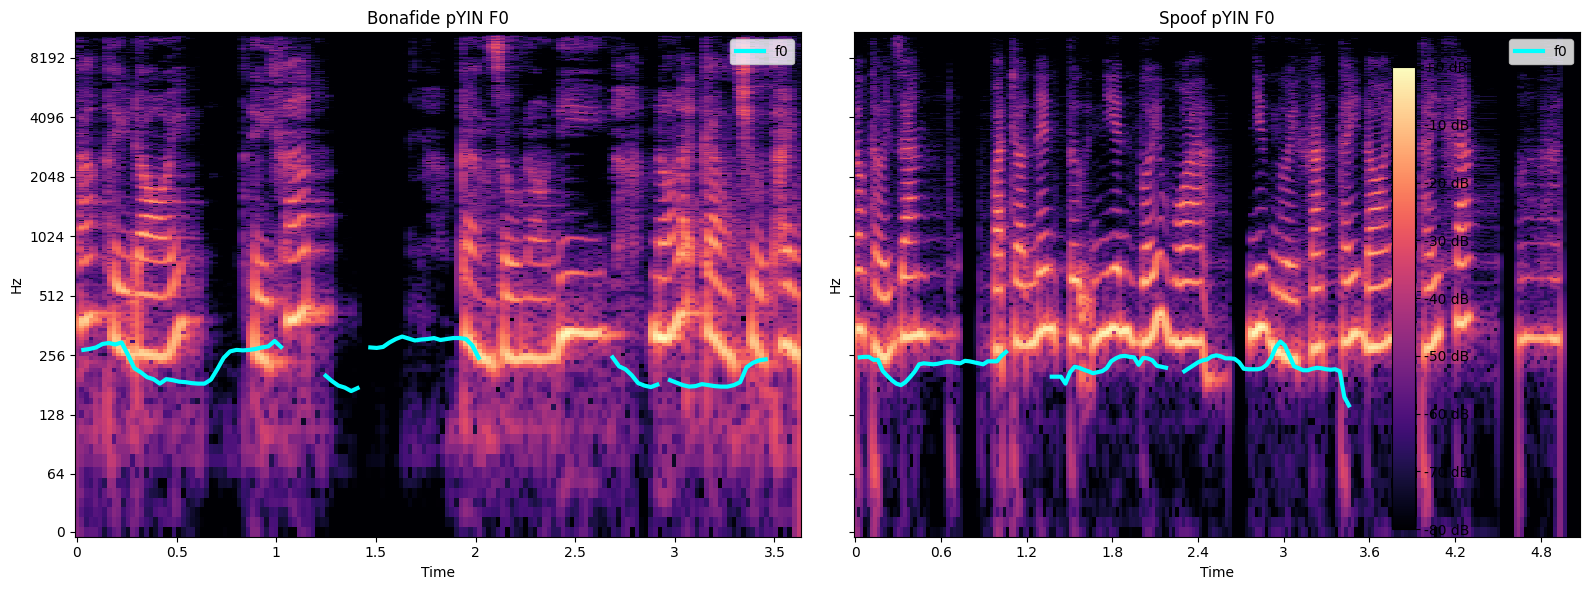

In [111]:
f0B, voiced_flag, voiced_probs = librosa.pyin(dataB,
                                             sr=srB,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))

f0S, voiced_flag, voiced_probs = librosa.pyin(dataS,
                                             sr=srS,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))

if len(f0B) < MX_TIME_STP:   
        f0B = np.pad(f0, (0, MX_TIME_STP - len(f0B)), mode='constant')
else:
    f0B = f0B[:MX_TIME_STP]
        
if len(f0S) < MX_TIME_STP:   
        f0S = np.pad(f0, (0, MX_TIME_STP - len(f0S)), mode='constant')
else:
    f0S = f0S[:MX_TIME_STP]


# Calculate time axes for each audio
timesB = librosa.times_like(f0B, sr=srB)
timesS = librosa.times_like(f0S, sr=srS)

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Bonafide audio
D_b = librosa.amplitude_to_db(np.abs(librosa.stft(dataB)), ref=np.max)
img_b = librosa.display.specshow(D_b, x_axis='time', y_axis='log', ax=axs[0])
axs[0].plot(timesB, f0B, label='f0', color='cyan', linewidth=3)
axs[0].set_title('Bonafide pYIN F0')
axs[0].legend(loc='upper right')

# Spoof audio
D_s = librosa.amplitude_to_db(np.abs(librosa.stft(dataS)), ref=np.max)
img_s = librosa.display.specshow(D_s, x_axis='time', y_axis='log', ax=axs[1])
axs[1].plot(timesS, f0S, label='f0', color='cyan', linewidth=3)
axs[1].set_title('Spoof pYIN F0')
axs[1].legend(loc='upper right')

# Shared colorbar
fig.colorbar(img_b, ax=axs, format="%+2.f dB", orientation='vertical', fraction=0.035, pad=0.08)

plt.tight_layout()
plt.show()